In [1]:
import math 
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import os; 
print(os.getcwd())
import cvxpy as cp
from multiprocessing import Pool
from joblib import Parallel, delayed

c:\Users\TGY\MIT Dropbox\Wallace Yion\Research\Braatz\Fourth Paper\Submission Code\Multistep Koopman


In [2]:
def _box_tensors(box, dtype, device):
    box = torch.as_tensor(box, dtype=dtype, device=device)  # shape (2,2): [[xmin,xmax],[ymin,ymax]]
    xmin, xmax = box[:,0], box[:,1]
    alpha = 0.5*(xmax - xmin)          # scale
    beta  = 0.5*(xmax + xmin)          # offset
    return xmin, xmax, alpha, beta

def to_box_scaled(X, box):
    """Map raw X (N,2) to U in [-1,1]^2 for an arbitrary box."""
    xmin, xmax, alpha, beta = _box_tensors(box, X.dtype, X.device)
    return (X - beta) / (alpha + 1e-12)

def from_box_scaled(U, box):
    """Inverse: map U in [-1,1]^2 back to raw X."""
    xmin, xmax, alpha, beta = _box_tensors(box, U.dtype, U.device)
    return alpha*U + beta

# ---------- 1D Legendre (orthonormal on [-1,1]) ----------
def legendre1d_orthonorm(x, deg):
    """
    φ_n(x) = sqrt((2n+1)/2) * P_n(x), with P_0=1, P_1=x, P_{n+1} = ((2n+1)xP_n - nP_{n-1})/(n+1)
    x: (N,) in [-1,1]. Returns Phi: (N, deg+1).
    """
    x = x.reshape(-1, 1)
    N = x.shape[0]
    Phi = torch.zeros((N, deg+1), dtype=x.dtype, device=x.device)
    Phi[:, 0] = math.sqrt(0.5)
    if deg == 0: return Phi
    Phi[:, 1] = math.sqrt(1.5) * x.squeeze(1)
    P0 = torch.ones_like(x)     # P_0
    P1 = x.clone()              # P_1
    for n in range(1, deg):
        P2 = ((2*n+1)*x*P1 - n*P0) / (n+1)    # P_{n+1}
        Phi[:, n+1] = math.sqrt((2*n+3)/2.0) * P2.squeeze(1)
        P0, P1 = P1, P2
    return Phi

# ---------- 2D tensor-product Legendre dictionary on an arbitrary box ----------
def legendre2d_phi_box(X, box, deg, include_bias=True, total_degree=True , verbose = False):
    """
    X:   (N,2) raw states (any rectangle)
    box: [[xmin,xmax],[ymin,ymax]]
    deg: max polynomial degree
    include_bias: prepend constant 1 column
    total_degree: keep (i,j) with i+j<=deg (True) or full grid (False)

    Returns:
      Z:         (N,p) dictionary built on scaled coords U∈[-1,1]^2
      Csel_u:    (2,p) linear decoder to recover U from Z
      Csel_x:    (2,p) linear decoder to recover raw X from Z (uses bias for offset)
      pairs:     list of (i,j) for each non-bias column in Z
    """
    assert X.shape[1] == 2
    # scale to unit box
    U = to_box_scaled(X, box)                 # (N,2) in [-1,1]^2
    x, y = U[:,0], U[:,1]

    Phi_x = legendre1d_orthonorm(x, deg)      # (N,deg+1)
    Phi_y = legendre1d_orthonorm(y, deg)

    cols, pairs = [], []
    if include_bias:
        cols.append(torch.ones((X.shape[0],1), dtype=X.dtype, device=X.device))

    for i in range(deg+1):
        for j in range(deg+1):
            if i == 0 and j == 0:
                continue  # bias already added
            if total_degree and (i+j > deg):
                continue
            cols.append(Phi_x[:, i:i+1] * Phi_y[:, j:j+1])  # φ_i(x)*φ_j(y)
            pairs.append((i,j))

    Z = torch.cat(cols, dim=1)                # (N,p)

    # decoder to U uses columns (1,0) and (0,1):
    # φ1(x)φ0(y) = (sqrt(3)/2)*x, φ0(x)φ1(y) = (sqrt(3)/2)*y
    s = math.sqrt(3.0) / 2.0
    off = 1 if include_bias else 0
    try:
        idx10 = pairs.index((1,0)) + off
        idx01 = pairs.index((0,1)) + off
    except ValueError:
        raise RuntimeError("Dictionary lacks linear terms (1,0) and/or (0,1). Use deg>=1.")

    Csel_u = torch.zeros((2, Z.shape[1]), dtype=X.dtype, device=X.device)
    Csel_u[0, idx10] = 1.0 / s
    Csel_u[1, idx01] = 1.0 / s

    # decoder to raw X: x = alpha*u + beta (element-wise)
    _, _, alpha, beta = _box_tensors(box, X.dtype, X.device)  # shape (2,)
    Csel_x = alpha.unsqueeze(1) * Csel_u                       # scale the U rows
    if include_bias:
        Csel_x[:, 0] += beta                                   # add offsets via bias colum
    
    if verbose:
        return Z, Csel_u, Csel_x, U, pairs
    return Z


def decode_legendre2d(Z, pairs, box, include_bias=True):
    """
    Recover U (scaled coords) and X (original coords) from the dictionary Z
    built by your legendre2d_phi_box(...).

    Args:
      Z:   (N,p) feature matrix
      pairs: list of (i,j) for the non-bias columns (exactly as returned)
      box: [[xmin,xmax],[ymin,ymax]]
      include_bias: True if Z's first column is the bias 1

    Returns:
      U_hat: (N,2) in [-1,1]^2
      X_hat: (N,2) in original coordinates
    """
    # indices of linear terms
    off = 1 if include_bias else 0
    try:
        idx10 = pairs.index((1,0)) + off
        idx01 = pairs.index((0,1)) + off
    except ValueError:
        raise RuntimeError("Need linear terms (1,0) and (0,1); use deg >= 1.")

    # With your orthonormalization: φ1(x)=√(3/2) x, φ0(y)=√(1/2),
    # so φ1(x)φ0(y) = (√3/2) x, same for y.
    s = math.sqrt(3.0) / 2.0

    dtype, device = Z.dtype, Z.device
    U_hat = torch.empty((Z.shape[0], 2), dtype=dtype, device=device)
    U_hat[:, 0] = Z[:, idx10] / s
    U_hat[:, 1] = Z[:, idx01] / s

    # Rescale to raw coordinates: x = alpha * u + beta (per axis)
    xmin, xmax = box[0]
    ymin, ymax = box[1]
    alpha = torch.tensor([(xmax - xmin)/2.0, (ymax - ymin)/2.0], dtype=dtype, device=device)
    beta  = torch.tensor([(xmax + xmin)/2.0, (ymax + ymin)/2.0], dtype=dtype, device=device)

    X_hat = U_hat * alpha + beta
    return U_hat, X_hat

In [3]:
# -------------------- Config --------------------
SEED     = 7
rng      = np.random.default_rng(SEED)

mu      = 5.0
w0       = 0.8
b        = 1.0

Ts       = 0.01        # step (s)
T_steps  = 21       # steps per trajectory
N_traj   = 20000          # number of trajectories (distinct theta/ICs)

# Input (PRBS-like)
U_AMP      = 0.5
MIN_HOLD   = 10         # min dwell (steps)
MAX_HOLD   = 40         # max dwell (steps)

SAVE_PATH = "vdp_multistep.npz"  # output file

# --------------- Van der Pol + RK4 ---------------
def vdp_rhs(x, u, mu, w0, b):
    x1, x2 = x
    dx1 = x2
    dx2 = mu * (1.0 - x1**2) * x2 - (w0**2) * x1 + b * u
    return np.array([dx1, dx2], dtype=np.float64)

def rk4_step(x, u, dt, mu, w0, b):
    k1 = vdp_rhs(x, u, mu, w0, b)
    k2 = vdp_rhs(x + 0.5*dt*k1, u, mu, w0, b)
    k3 = vdp_rhs(x + 0.5*dt*k2, u, mu, w0, b)
    k4 = vdp_rhs(x + dt*k3, u, mu, w0, b)
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)



def make_prbs_sequence(T, amp, rng, min_hold=10, max_hold=40):
    """Piecewise-constant ±amp with random dwell lengths (in steps)."""
    seq = np.empty(T, dtype=np.float64)
    t = 0
    while t < T:
        hold = int(rng.integers(min_hold, max_hold + 1))
        val = amp if rng.random() < 0.5 else -amp
        seq[t:t+hold] = val
        t += hold
    return seq[:T]

# --------------- Dataset generation ---------------
def generate_dataset(N_traj, T_steps, Ts, rng):
    n, m = 2, 1
    Xs, Ys, Us = [], [], []
    for _ in range(N_traj):      # θ ∈ [-1,1]

        x = rng.uniform(-2.0, 2.0, size=(2,)).astype(np.float64)
        # Input sequence
        u_seq = make_prbs_sequence(T_steps, U_AMP, rng, MIN_HOLD, MAX_HOLD)

        # Simulate
        X_traj = np.empty((n, T_steps), dtype=np.float64)
        for k in range(T_steps):
            X_traj[:, k] = x
            x = rk4_step(x, u_seq[k], Ts, mu, w0, b)

        # Snapshots
        Xs.append(X_traj[:, :-1])               # x_k
        Ys.append(X_traj[:, 1:])                # x_{k+1}
        Us.append(u_seq[:-1][None, :])          # u_k

    X = np.stack(Xs, axis=0)              # (2, N)
    Y = np.stack(Ys, axis=0)              # (2, N)
    U = np.stack(Us, axis=0)              # (1, N)
    return X, Y, U

if __name__ == "__main__":
    X, Y, U = generate_dataset(N_traj, T_steps, Ts, rng)

    np.savez_compressed(
        SAVE_PATH, X=X, Y=Y, U=U,
        Ts=Ts, mu=mu, w0=w0, b=b,N_traj=N_traj,T_steps=T_steps,
        meta=dict(
            description="Van der Pol dataset for Multistep Koopman",
            seed=SEED, N_traj=N_traj, T_steps=T_steps
        )
    )

    print("Saved:", SAVE_PATH)
    print("Shapes:",
          "X", X.shape, "Y", Y.shape, "U", U.shape)

Saved: vdp_multistep.npz
Shapes: X (20000, 2, 20) Y (20000, 2, 20) U (20000, 1, 20)


In [4]:
# ---- load or create your data as numpy arrays (columns = samples) ----
# X: (n, N), Y: (n, N), U: (m, N), THETA: (N,)
# For demo, we'll create placeholders; replace these with your data.
n, m = X.shape[1], U.shape[1]
# ---------- build features (ψ) ----------


X_init = torch.tensor(X[:, :, 0])
Yt = torch.tensor(Y)

# X,Y are torch tensors of shape (N,2) in *raw* units
box = [[-2.0, 2.0], [-2.0, 2.0]]   # <-- your rectangle (can be symmetric [-L,L],[-L,L] too)
deg_poly = 10
Z, Csel_u, Csel_x, _, pairs = legendre2d_phi_box(X_init, box, deg_poly, include_bias=True, total_degree=True, verbose=True)                       # (N, p)
# ---- feature-wise standardization (learn from Z; use train split if you have one) ----

print(Z.shape)
print(Yt.shape)
p  = Z.shape[1]

# decode matrix: first n features are the raw x (by construction)
Csel = torch.zeros((n, p)); Csel[:, :n] = torch.eye(n)



torch.Size([20000, 66])
torch.Size([20000, 2, 20])


In [12]:
n_x, m, N = 2, 1, 20
def edmdc(X, Y, U, psi, lam=0.0):
    """One-step EDMDc (Koopman with control)
    X, Y: (N × n_x)
    U: (N × m)
    psi: lifting function ψ(x) → ℝ^p
    lam: ridge regularization
    Returns A, B such that ψ(x_{t+1}) ≈ A ψ(x_t) + B u_t
    """
    Psi_X = psi(X)
    print(Psi_X.shape)
    Psi_Y = psi(Y)
    H = np.hstack([Psi_X, U])
    G = H.T @ H + lam * np.eye(H.shape[1])
    print(np.linalg.cond(G))
    AB = np.linalg.solve(G, H.T @ Psi_Y)
    p = Psi_X.shape[1]
    A = AB[:p, :]
    B = AB[p:, :]
    return A, B

print(X.shape, Y.shape, U.shape)
X_flat = X[:, :, 0].reshape(-1, n_x)   # all x_t
Y_flat = Y[:, :, 0].reshape(-1, n_x)   # all x_{t+1}
U_flat = U[:, :, 0].reshape(-1, m)     # all u_t
print(X_flat.shape, Y_flat.shape, U_flat.shape)

psi = lambda x: legendre2d_phi_box(torch.tensor(x), box, deg_poly,
                                   include_bias=True, total_degree=True).numpy()

A, B = edmdc(X_flat, Y_flat, U_flat, psi, lam=1e-3)
print("Spectral Radius:", np.max(np.absolute(np.linalg.eigvals(A))))

print("A shape:", A.shape)
print("B shape:", B.shape)

(20000, 2, 20) (20000, 2, 20) (20000, 1, 20)
(20000, 2) (20000, 2) (20000, 1)
(20000, 66)
5.803508528266264
Spectral Radius: 1.3812940956273008
A shape: (66, 66)
B shape: (1, 66)


In [6]:
# --- EDMDc rollout using your decoder ---
def open_loop_rollout_edmdc_decoded(A, B, psi, x0, U_seq, pairs, box, include_bias=True):
    """
    ψ_{t+1} = ψ_t A + u_t B, then decode ψ_{t+1} → x_{t+1} via decode_legendre2d
    x0: (1, n_x), U_seq: (H, m)
    returns X_pred: (H, n_x)
    """
    x = x0.copy()
    traj = []
    for k in range(U_seq.shape[0]):
        psi_x   = psi(x)                           # (1, p) numpy
        psi_nxt = psi_x @ A + U_seq[k:k+1] @ B  # (1, p) numpy
        # decode using your function (expects torch tensors)
        Z_torch = torch.tensor(psi_nxt)            # (1, p)
        _, X_hat = decode_legendre2d(Z_torch, pairs, box, include_bias=include_bias)
        x = X_hat.cpu().numpy()                    # (1, n_x)
        traj.append(x.squeeze())
    return np.vstack(traj)


def edmdc_mse_timewise_decoded(A, B, psi, X, Y, U, pairs, box, N_max = 10000000000, include_bias=True):
    Ntraj, n_x, H = X.shape
    Y_pred_all = np.zeros_like(Y[0:min(Ntraj,N_max)])
    for i in range(min(Ntraj,N_max)):
        x0    = X[i, :, 0:1].T        # (1, n_x)
        U_seq = U[i].T                # (H, m)
        Y_pred = open_loop_rollout_edmdc_decoded(A, B, psi, x0, U_seq, pairs, box, include_bias)
        Y_pred_all[i] = Y_pred.T
    err = (Y[0:min(Ntraj,N_max)]  - Y_pred_all)**2
    return err.mean(axis=(0, 1))

# usage
mse_t_edmdc  = edmdc_mse_timewise_decoded(A, B, psi, X, Y, U, pairs, box, N_max = 1000, include_bias=True)
print("Per-step MSE:", mse_t_edmdc)


KeyboardInterrupt: 

In [ ]:
#export mse_t_edmdc to npz file
np.savez_compressed("vdp_edmdc_mse.npz", mse_t_edmdc = mse_t_edmdc)


traj 6246: first 10 rows (true | pred)
[[-0.79978612 -1.36453478 -0.79978626 -1.36462539]
 [-0.81350156 -1.37832705 -0.81350276 -1.37850744]
 [-0.82734795 -1.39070744 -0.82735109 -1.39097632]
 [-0.84131069 -1.40158267 -0.84131665 -1.40193828]
 [-0.85537429 -1.41086335 -0.85538392 -1.41130342]
 [-0.86952236 -1.41846501 -0.86953651 -1.41898675]
 [-0.88373773 -1.42430911 -0.88375719 -1.42490921]
 [-0.89800245 -1.42832401 -0.89802798 -1.42899863]
 [-0.9122979  -1.43044601 -0.91233024 -1.43119081]
 [-0.92660487 -1.43062025 -0.9266447  -1.43143037]]

traj 17726: first 10 rows (true | pred)
[[-1.22686971 -1.12416221 -1.22686939 -1.12413362]
 [-1.2379042  -1.08265194 -1.23790326 -1.08259189]
 [-1.24852139 -1.04073212 -1.24851952 -1.04063827]
 [-1.25871803 -0.99856821 -1.25871488 -0.99843871]
 [-1.26849247 -0.95631856 -1.26848768 -0.95615202]
 [-1.27784461 -0.91413326 -1.27783781 -0.91392873]
 [-1.28677582 -0.87215321 -1.28676662 -0.87191011]
 [-1.2952888  -0.83050936 -1.29527682 -0.83022743]


C:\Users\TGY\AppData\Local\Temp\ipykernel_11204\2518376388.py:12: RuntimeWarning: invalid value encountered in matmul
  psi_nxt = psi_x @ A + U_seq[k:k+1] @ B  # (1, p) numpy



traj 7697: first 10 rows (true | pred)
[[-0.50784136 -0.91162109 -0.50784083 -0.91148841]
 [-0.51713684 -0.94761133 -0.51713442 -0.94734163]
 [-0.52679628 -0.98440926 -0.52679059 -0.98399838]
 [-0.53682759 -1.0219765  -0.53681718 -1.02142056]
 [-0.54723823 -1.0602672  -0.54722163 -1.05956265]
 [-0.55803517 -1.09922739 -0.55801087 -1.09837112]
 [-0.5692248  -1.1387944  -0.56919128 -1.13778384]
 [-0.58081284 -1.17889631 -0.58076853 -1.17772952]
 [-0.59280424 -1.21945138 -0.59274757 -1.21812713]
 [-0.60520307 -1.26036751 -0.60513245 -1.25888539]]


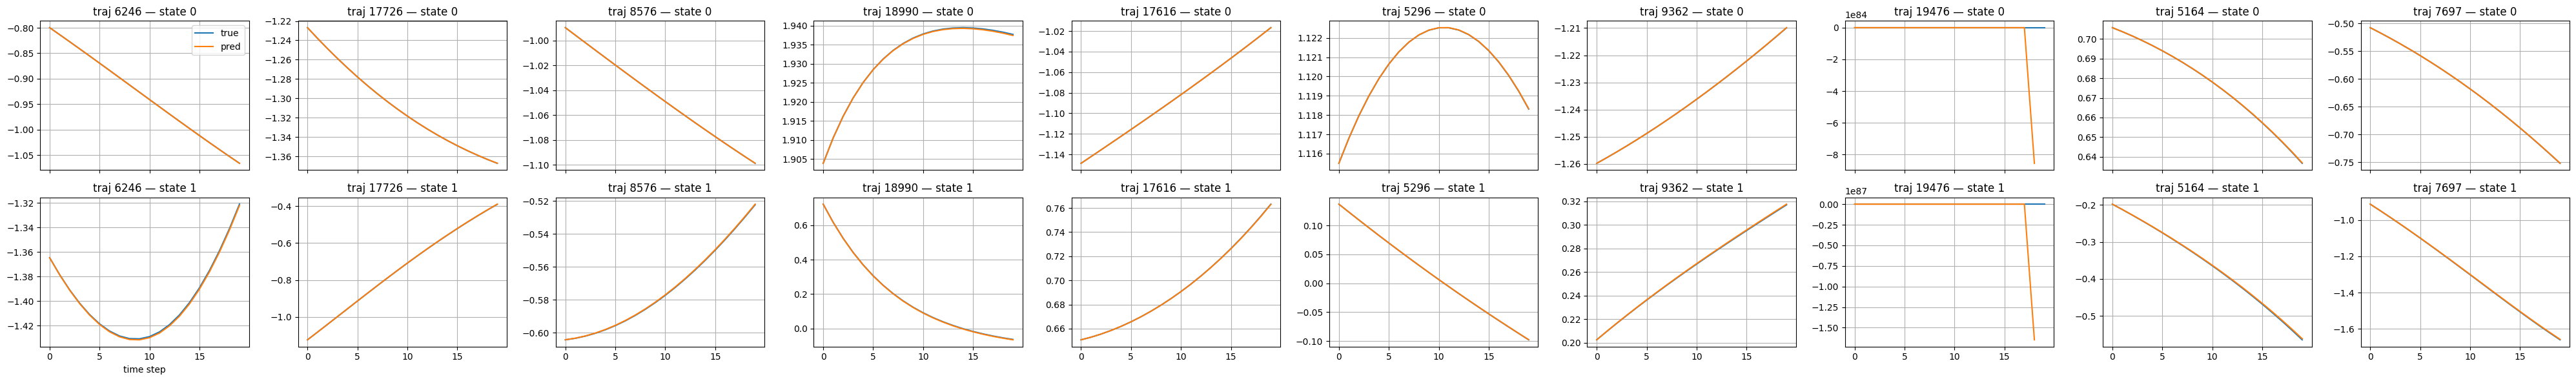

In [ ]:
import matplotlib.pyplot as plt
import random
def edmdc_traj(A, B, psi, X, Y, U, pairs, box, idx):
    """
    Return (Y_true, Y_pred) for trajectory idx.
    X,Y: (Ntraj,n_x,H), U:(Ntraj,m,H)
    """
    x0    = X[idx, :, 0:1].T              # (1, n_x)
    U_seq = U[idx].T                      # (H, m)
    # rollout with your decoder
    Y_pred = open_loop_rollout_edmdc_decoded(A, B, psi, x0, U_seq, pairs, box, include_bias=True)  # (H,n_x)
    Y_true = Y[idx].T                     # (H, n_x)
    return Y_true, Y_pred

# --- print a few ---
def print_sample_trajs(A, B, psi, X, Y, U, pairs, box, idxs=(0,1,2), max_rows=5):
    for idx in idxs:
        Y_true, Y_pred = edmdc_traj(A, B, psi, X, Y, U, pairs, box, idx)
        print(f"\ntraj {idx}: first {max_rows} rows (true | pred)")
        arr = np.hstack([Y_true[:max_rows], Y_pred[:max_rows]])
        print(arr)

# --- plot a few ---
def plot_sample_trajs(A, B, psi, X, Y, U, pairs, box, idxs=(0,1,2)):
    ncols = len(idxs)
    H     = X.shape[2]
    fig, axes = plt.subplots(2, ncols, figsize=(4*ncols, 6), sharex=True)
    if ncols == 1:
        axes = np.array([[axes[0]],[axes[1]]])  # make 2x1 to index consistently
    t = np.arange(H)

    for j, idx in enumerate(idxs):
        Y_true, Y_pred = edmdc_traj(A, B, psi, X, Y, U, pairs, box, idx)
        # state 0
        axes[0, j].plot(t, Y_true[:, 0], label="true")
        axes[0, j].plot(t, Y_pred[:, 0], label="pred")
        axes[0, j].set_title(f"traj {idx} — state 0")
        axes[0, j].grid(True)
        # state 1
        axes[1, j].plot(t, Y_true[:, 1], label="true")
        axes[1, j].plot(t, Y_pred[:, 1], label="pred")
        axes[1, j].set_title(f"traj {idx} — state 1")
        axes[1, j].grid(True)

    axes[1, 0].set_xlabel("time step")
    axes[0, 0].legend()
    plt.tight_layout()
    plt.show()

# --- usage ---
# choose a few indices (or random):
idxs = random.sample(range(X.shape[0]), 10)
print_sample_trajs(A, B, psi, X, Y, U, pairs, box, idxs=idxs, max_rows=10)
plot_sample_trajs(A, B, psi, X, Y, U, pairs, box, idxs=idxs)


#6159 11426

In [ ]:
#print trajectories with high but not highest mse
mse_per_traj = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    Y_true, Y_pred = edmdc_traj(A, B, psi, X, Y, U, pairs, box, i)
    err = (Y_true - Y_pred)**2
    mse_per_traj[i] = err.mean()   
#get indices of top 5 highest mse excluding the maximum
top_5_indices = np.argsort(mse_per_traj)[-100:-95]  
print_sample_trajs(A, B, psi, X, Y, U, pairs, box, idxs=top_5_indices, max_rows=10)
plot_sample_trajs(A, B, psi, X, Y, U, pairs, box, idxs=top_5_indices)

C:\Users\TGY\AppData\Local\Temp\ipykernel_11204\2518376388.py:12: RuntimeWarning: invalid value encountered in matmul
  psi_nxt = psi_x @ A + U_seq[k:k+1] @ B  # (1, p) numpy
C:\Users\TGY\AppData\Local\Temp\ipykernel_11204\2137488566.py:5: RuntimeWarning: overflow encountered in square
  err = (Y_true - Y_pred)**2


KeyboardInterrupt: 

In [ ]:
#save data from trajectory 6159 11426 (both predicted and true)
idxs = [6159, 11426]
Y_true, Y_pred = edmdc_traj(A, B, psi, X, Y, U, pairs, box, idxs[0])    
np.savez_compressed("vdp_edmdc_traj_6159.npz", Y_true = Y_true, Y_pred = Y_pred)
np.savez_compressed("vdp_edmdc_traj_11426.npz", Y_true = Y_true, Y_pred = Y_pred)